<div style="width:90%; text-align:center; border-width: 0px; display:block; margin-left:auto; margin-right:auto; background-color:off white; position: relative;">
  <div class="alert alert-block alert-success" style="text-align:center; color:white; background-color:#1e2124 !important;">
    <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_unb.png" style="width: 200px; opacity:0.85;">
    <h1>Universidade de Brasília</h1>
    <h2>Instituto de Física</h2>
    <hr style="width:44%;border:1px solid white;">
    <h3>Mini Curso de Inteligência Artificial para a Física</h3> 
    <h4>Henrique de Oliveira Noronha</h4>
    <hr style="width:44%;border:1px solid white;">
  </div>
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_if.png" style="position: absolute; bottom: 20px; left: 40px; width: 100px;">
</div>


# **➲ Aula 4 - Redes Neurais Informadas pela Física (PINNs) para Resolução de EDPs**

O processo para resolver EDPs com PINNs é muito similar ao de resolver EDOs, porém há algumas diferenças a ser tratadas. A primeira delas é a obtenção dos dados, tome por exemplo a equação de Schrodinger dependente no tempo unidimensional. Nesse caso, temos uma malha bidimensional de posição e tempo, então, é possível fazer o treinamento com dados em posições aleatórias e tempos aleatórios que, com número suficiente, tornaria nossa solução única. Porém também poderíamos informar as condições de contorno do problema que queremos analisar, nesse exemplo, informaráamos a função de onda no tempo inicial. Essa última abordagem é a que iremos tratar nessa aula, pois pegar dados aleatórios da solução requer que a resolvamos numericamente antes, ou que tenhamos dados experimentais, e ambos são mais difíceis de conseguir do que para EDOs.

As outras diferenças estão no loop de treinamento, suponha que tenhamos uma EDP da seguinte forma:

\begin{equation*}
    f_1(x,y)\frac{\partial² u}{\partial x²} + f_2(x,y)\frac{\partial² u}{\partial y²} + f_3(x,y)\frac{\partial² u}{\partial xy} + f_4(x,y)\frac{\partial u}{\partial x} + f_5(x,y)\frac{\partial u}{\partial y} + f_6(x,y) = 0
\end{equation*}

Então, a primeira diferença é que o tensor de entrada de treinamento físico seria agora de shape (n_batches,2), ao invés de (n_batches,1) como em EDOs, pois temos que informar tanto x quanto y. Isso evidentemente que aumenta muito mais a complexidade do treinamento, pois se quisemos fazer como no nosso exemplo da aula passada, que nosso x e y vão de 0 a 10 com intervalos de 0.1, isso resultará em uma malha de 10000 pontos, ao invés de somente 100. Além disso, como informamos um tensor com 2 (ou mais) features, não podemos utilizar o tape.gradient para obter os gradientes, ao invés disso, teremos que usar o batch_jacobian, que consegue calcular as derivadas parciais. Vamos fazer alguns exemplos para melhorar o entendimento:

Primeiramente, vamos fazer um escoamento de Poiseuille em um duto retangular, a EDP que rege esse sistema é:

\begin{equation*}
    \frac{\partial² w}{\partial x²} + \frac{\partial² w}{\partial y²} = -\frac{G}{\mu}
\end{equation*}

Onde w(x,y) é a velocidade do fluido, G é o gradiente de pressão e $\mu$ é a viscosidade dimâmica do fluido. Nesse caso, a condição de contorno é uma de Dirichlet, em que a velocidade do fluido na fronteira da geometria é 0, ou seja $w_{\partial \Omega} = 0$. Temos que construir então 3 tensores antes de treinar o modelo, o tensor das entradas que será as coordenadas das paredes, o tensor de saídas, que será um tensor só contendo zeros e o tensor de entrada de treinamento físico, que será uma malha igualmente distribuída dentro da nossa geometria. Note que o escoamento de Poiseuille é um escoamento laminar, por isso não temos que nos preocupar com o tempo.

Vamos considerar nossa gemoetria um retângulo 1.5 $\times$ 1.0 e vamos considerar que $\frac{G}{\mu} = 1.0$

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [111]:
dx = 0.05
x_inicial = 0
x_final = 1.0
y_inicial = 0
y_final = 1.0

xs = np.arange(x_inicial, x_final+dx, dx ,dtype="float32")
ys = np.arange(y_inicial, y_final+dx, dx ,dtype="float32")
sigma = []
paredes = []

for x in xs:
    for y in ys:
        if x==0 or y == 0 or x==x_final or y==y_final: # Condições que definem as paredes
            paredes.append([x,y])
        sigma.append([x, y]) # Podemos colocar as paredes no sigma também, pois elas também têm que obedecer à EDP

entradas_treinamento_fisico = tf.convert_to_tensor(sigma,dtype=tf.float32)
entradas_treinamento = tf.convert_to_tensor(paredes)
saidas_treinamento = tf.expand_dims(tf.zeros(len(entradas_treinamento)),1) # Vetor com 0s de shape (n_batches, 1)

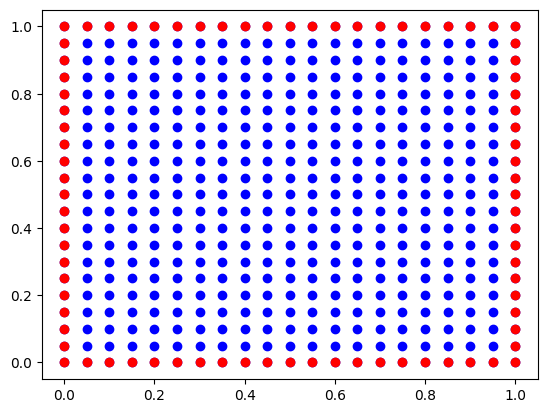

In [112]:
plt.scatter(entradas_treinamento_fisico[:,0],entradas_treinamento_fisico[:,1], color = "blue")
plt.scatter(entradas_treinamento[:,0],entradas_treinamento[:,1],color = "red")
plt.show()

In [237]:
modelo = Sequential([Input((2,)),
                    Dense(64,activation="tanh"),
                    Dense(64,activation="tanh"),
                    Dense(1,activation="linear")])

In [244]:
taxa_de_treinamento = 0.0005
k_fisica = 1e-2

otimizador = Adam(learning_rate=taxa_de_treinamento)

@tf.function # Isso acelera a função
def loop_treinamento_PINN(entradas,saidas,x_fis,k_fisica): #entradas e saídas são as que damos para o modelo e x_fis é o tensor de entradas de treinamento físico
    with tf.GradientTape() as tape: # Fita responsável por pegar os gradientes da perda em relação ao modelo
        perda_normal = tf.reduce_mean(tf.square(modelo(entradas)-saidas)) # MSE padrão das saídas do modelo com as saídas dadas
        with tf.GradientTape() as t1:
            t1.watch(x_fis)
            with tf.GradientTape() as t2:
                t2.watch(x_fis)
                w = modelo(x_fis) # Posição do oscilador
            primeiras_derivadas = t2.batch_jacobian(w,x_fis)[:,0,:] # Retorna um tensor de shape (n_batches,2), onde a primeira feature é dw/dx e a segunda é dw/dy
        segundas_derivadas = t1.batch_jacobian(primeiras_derivadas,x_fis) # Retorna um tensor de shape (n_batches,2,2), que representa todas as segundas derivadas parciais
        d2wd2x = segundas_derivadas[:,0,0]  # ∂²w/∂x²
        d2wd2y = segundas_derivadas[:,1,1]  # ∂²w/∂y²
        EDP_sistema = d2wd2x + d2wd2y + 1.0
        perda_fisica = k_fisica*tf.reduce_mean(tf.square(EDP_sistema))
        perda_total = perda_normal + perda_fisica
    gradientes_modelo = tape.gradient(perda_total,modelo.trainable_variables)
    otimizador.apply_gradients(zip(gradientes_modelo,modelo.trainable_variables)) # Dá os gradientes para o otimizador ADAM minimizar a perda
    return perda_fisica, perda_normal, perda_total


In [245]:
epochs = 25000

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico,k_fisica)
    if (epoch)%5000 == 0:
        tf.print(epoch,fisica,normal,total)

0 8.81330707e-05 1.3449469e-06 8.94780169e-05
5000 1.0877e-05 5.72389172e-06 1.66008922e-05
10000 4.41055454e-06 2.16768603e-06 6.57824057e-06
15000 3.75617105e-06 4.04567727e-05 4.42129422e-05
20000 1.96682436e-06 1.50939331e-06 3.47621767e-06
25000 1.42654835e-06 5.31922615e-06 6.7457745e-06


Vamos fazer outra malha mais detalhada, com intervalos menores para ver como ficou a previsão final:

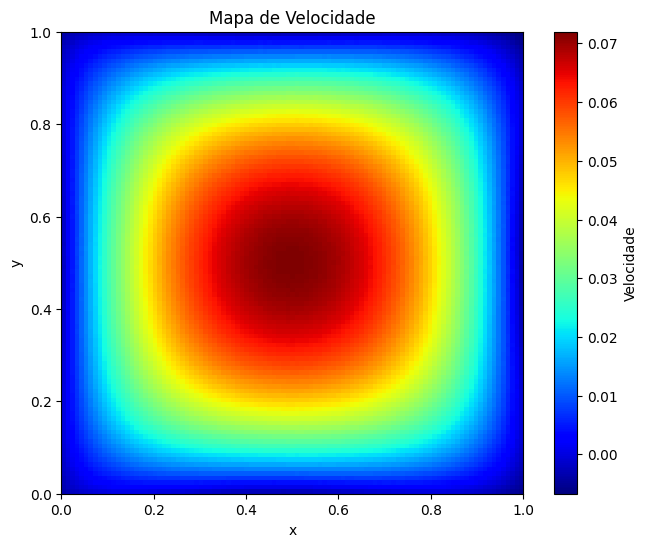

In [246]:
def plotar_velocidade():
    dx_plot = 0.01

    xs_plot = np.arange(x_inicial, x_final+dx_plot, dx_plot ,dtype="float32")
    ys_plot = np.arange(y_inicial, y_final+dx_plot, dx_plot ,dtype="float32")
    sigma_plot = []

    for x in xs_plot:
        for y in ys_plot:
            sigma_plot.append([x, y])

    sigma_plot = tf.convert_to_tensor(sigma_plot)
    prev = np.array(modelo(sigma_plot)).reshape(-1)
    cont1=0
    cont2=0
    valores_velocidade = np.zeros((len(xs_plot),len(ys_plot)))

    for i in range(len(sigma_plot)):
        valores_velocidade[cont1,cont2] = prev[i]
        cont2+=1
        if cont2==len(ys_plot):
            cont1+=1
            cont2=0


    plt.figure(figsize=(8, 6))
    plt.imshow(
        valores_velocidade, 
        extent=(x_inicial, x_final, y_inicial, y_final), 
        origin='lower', 
        cmap='jet', 
        interpolation='nearest'  
    )
    plt.colorbar(label='Velocidade')
    plt.title('Mapa de Velocidade')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

plotar_velocidade()

Note que o nosso mínimo da velocidade não está em 0 como deveria ser, isso pode ser amenizado com um loop de treinamento modificado, onde vamos gradualmente abaixando k_fisica conforme o modelo vai aprendendo a solução para ir enfatizando a condição de contorno de 0 na fronteira. Como uma solução temporária, vamos somente rodar novamente o treinamento com k_fisica menor.

0 7.06126428e-08 4.29737611e-06 4.36798882e-06
5000 1.6230301e-07 1.29920898e-06 1.46151194e-06
10000 1.80848261e-07 1.38573853e-06 1.56658677e-06
15000 1.99511149e-07 1.07214669e-06 1.27165788e-06
20000 2.17953868e-07 1.04321714e-06 1.26117106e-06
25000 2.29094198e-07 1.01140233e-06 1.24049654e-06
30000 2.47199523e-07 9.57587e-07 1.20478649e-06
35000 2.62049667e-07 2.0828179e-06 2.34486765e-06
40000 2.70007547e-07 8.98512383e-07 1.16851993e-06
45000 2.79271745e-07 3.02689091e-06 3.30616263e-06
50000 2.86533094e-07 1.83960606e-06 2.12613918e-06


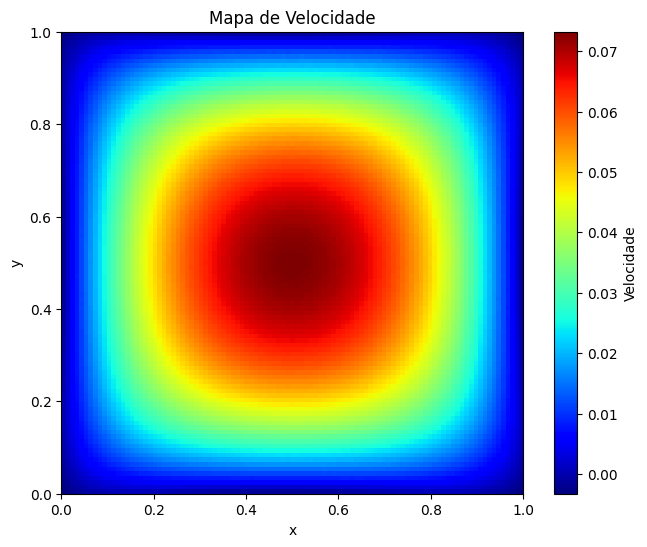

In [247]:
epochs = 50000
k_fisica = 5e-4

for epoch in range(epochs+1):
    fisica,normal,total = loop_treinamento_PINN(entradas_treinamento,saidas_treinamento,entradas_treinamento_fisico,k_fisica)
    if (epoch)%5000 == 0:
        tf.print(epoch,fisica,normal,total)

plotar_velocidade()

Melhorou um pouco, infelizmente essa tarefa é um pouco difícil de realizar e muitas vezes requer muita investigação e epochs, porém de qualquer forma, a forma da solução é basicamente essa. 